# Neural Network From Scratch With Numpy

### HW1 @ DL Course, Dr. Soleymani

*Full Name:* Mehdi Jamalkhah

In [6]:
!pip install future
!pip install pandas
!pip install torchvision

In [173]:
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.data import get_MNIST_data, get_normalized_MNIST_data, get_california_housing_data, get_california_housing_normalized__data
from builtins import range
import numpy as np
import matplotlib.pyplot as plt
from utils.solver import *
import pandas as pd
from sklearn.datasets import fetch_california_housing



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

# Affine layer: forward

In [5]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    cache = (x, w, b)
    x = x.reshape(x.shape[0], -1)
    out = np.matmul(x, w) + b
     
    return out, cache
    

Let's test the implementaion:

In [6]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])


# Compare the output with correct ones. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward

In [174]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """    
    x,w,b = cache
    dx = np.matmul(dout, w.T).reshape(x.shape)
    dw = np.matmul(x.reshape(x.shape[0], -1).T, dout)
    db = dout.sum(axis=0)
    
    return dx,dw,db

In [175]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward

In [176]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    cache = x
    out = np.maximum(0, x)
    return out, cache

In [177]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward

In [178]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache
    dx = dout * np.where(x > 0, 1, 0)
    return dx

Let's test the implementation using numeric gradient checking:

In [183]:
# Test the relu_backward function
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# Sigmoid activation: forward

In [180]:
def sigmoid_forward(x):
    """
    Computes the forward pass for a layer of Sigmoid.

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = 1 / (np.exp(-x) + 1)
    cache = x
    
    return out, cache

In [184]:
# Test the sigmoid_forward function

x = np.linspace(-6, 6, num=12).reshape(3, 4)

out, _ = sigmoid_forward(x)
correct_out = np.array([[0.00247262, 0.00732514, 0.0214955 , 0.06138311],
                        [0.16296047, 0.36691963, 0.63308037, 0.83703953],
                        [0.93861689, 0.9785045 , 0.99267486, 0.99752738]])

# Compare your output with correct ones. The error should be on the order of e-7
print('Testing sigmoid_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing sigmoid_forward function:
difference:  6.383174040859927e-07


# Sigmoid activation: backward

In [185]:
def sigmoid_backward(dout, cache):
    """
    Computes the backward pass for a layer of Sigmoid.

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache
    sigmoid_out = 1 / (np.exp(-x) + 1)
    dx = sigmoid_out * (1 - sigmoid_out) * dout
    return dx

Let's test the implementation using numeric gradient checking:

In [186]:
# Test the sigmoid_backward function
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: sigmoid_forward(x)[0], x, dout)

_, cache = sigmoid_forward(x)
dx = sigmoid_backward(dout, cache)

# The error should be on the order of e-11
print('Testing sigmoid_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing sigmoid_backward function:
dx error:  3.446520386706568e-11


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. We will implement the forward and backward pass for the affine layer followed by a ReLU nonlinearity in the `affine_relu_forward` and `affine_relu_backward` functions. 

In [188]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that performs an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    out, fc_cache = affine_forward(x, w, b)
    out , relu_cache = relu_forward(out)
    cache = (fc_cache, relu_cache)
    return out, cache
    

In [189]:
def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    
    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (fc_cache, relu_cache)
      
    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    fc_cache, relu_cache = cache
    relu_dx = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(relu_dx, fc_cache)
    return dx, dw, db

Let's test the implementation using numeric gradient checking:

In [190]:
# Test the affine_relu_backward function

np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Batch Normalization: Forward Pass

In [20]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var: Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == "train":
        # We use minibatch statistics to compute the mean and variance, and use    
        # these statistics to normalize the incoming data, and scale and    
        # shift the normalized data using gamma and beta.                   
                              
        # Any intermediates that we need for the backward pass should be                                                 #
        # stored in the cache variable.                                     
                                                                           
        # We also use the computed sample mean and variance together        
        # with the momentum variable to update the running mean and running 
        # variance, storing the result in the running_mean and running_var  
        # variables.                                                        
                                                                 
        # Note that though we should be keeping track of the running        
        # variance, we should normalize the data based on the standard      
        # deviation (square root of variance) instead!                      
        sample_mean = x.mean(axis=0)
        sample_var = x.var(axis=0)
        
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        
        std = np.sqrt(sample_var + eps)
        normalized_x = (x - sample_mean) / std
        out = gamma * normalized_x + beta
        
        cache = x, normalized_x, sample_mean, std, gamma
    elif mode == "test":
        # We use the running mean and variance to normalize the incoming data,  
        # then scale and shift the normalized data using gamma and beta.
        out = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * out + beta
        cache = tuple()
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache

Let's test the implementation:

In [191]:
# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))

# Means should be close to zero and stds close to one.
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])

# Now means should be close to beta and stds close to gamma.
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means: [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means: [ 5.55111512e-17  3.66373598e-17 -5.27355937e-18]
  stds:  [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means: [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]



In [22]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means: [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]



# Batch Normalization: Backward Pass
Now we implement the backward pass for batch normalization in the function `batchnorm_backward`.

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 

we first calculate the mean $\mu$ and variance $var$.
With $\mu$ and $var$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  var=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

Batchnorm Graph:

![](https://i.postimg.cc/HkbSxNkF/batchnorm-graph.png)

We make sure each of the intermediary gradient derivations are all as simplified as possible, for ease of implementation.

In [195]:
def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    x, normalized_x, mean, std, gamma = cache
    N, D = dout.shape
    
    dx = (1 / N) * gamma * (std ** -1) * (N * dout - dout.sum(axis=0) - \
        (x - mean) * (std ** -2) * ((x - mean) * dout).sum(axis=0))
    dgamma = (normalized_x * dout).sum(axis=0)
    dbeta = dout.sum(axis=0)
    
    return dx, dgamma, dbeta

Let's check the backward pass.

In [196]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

# We expect to see relative errors between 1e-13 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.70292739451216e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


# Loss layer: Softmax
Now we implement the loss and gradient for softmax in the `softmax_loss` function.

In [25]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N, C = x.shape
    loss = 0.0
    dx = np.zeros_like(x)

    for i in range(N):
        scores = x[i, :]
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores)

        loss -= np.log(probs[int(y[i])])

        dx[i, :] = probs
        dx[i, int(y[i])] -= 1

    loss /= N
    dx /= N
    return loss,dx

We make sure that the implementations are correct by running the following:

In [197]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.736508787182764e-09


# Loss layer: MSE
Now we implement the loss and gradient for mean squared error in the `mse_loss` function.

In [202]:
def mse_loss(x, y):
    """
    Computes the loss and gradient for MSE loss.

    Inputs:
    - x: Input data, of shape (N,) where x[i] is the predicted vector for 
        the ith input.
    - y: Vector of target values, of shape (N,) where y[i] is the target value
        for the ith input.

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    MSE = np.square(x - y).mean()
    dx = (2/N) *(x - y)

    return MSE, dx.reshape(dx.shape[0], -1)

We can make sure that the implementations are correct by running the following:

In [207]:
np.random.seed(231)
num_inputs = 50
x = np.random.randn(num_inputs)
y = np.random.randn(num_inputs)

dx_num = eval_numerical_gradient(lambda x: mse_loss(x, y)[0], x, verbose=False).reshape(num_inputs, -1)
loss, dx = mse_loss(x, y)
# Test mse_loss function. Loss should be close to 1.9 and dx error should be around e-9
print('\nTesting mse_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing mse_loss:
loss:  1.8672282748726519
dx error:  2.8607953262121067e-09


# Multi-Layer Fully Connected Network
In this part, We will implement a fully connected network with an arbitrary number of hidden layers.

In [212]:
class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function for a classification problem or the MSE loss function for 
    a regression problem. This will also implement batch normalization as an option. 
    For a network with L layers, the architecture will be

    {affine - [batchnorm] - relu} x (L - 1) - affine - softmax/mse

    where batch normalization is optional in each layer and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        category,
        hidden_dims,
        normalization,
        input_dim=784,
        output_dim=10,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - category: The type of the problem. Valid values are "classification",
            "regression".
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - normalization: A list of booleans which shows that we have batch 
            normalization after the affine layer.
        - input_dim: An integer giving the size of the input.
        - output_dim: An integer giving the number of classes to classify. It
            is 1 for a regression problem.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        """
        self.category = category
        self.normalization = normalization + [False]
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}
        self.num_classes = output_dim

        # We storing all values in the self.params dictionary. Also we store weights  
        # and biases for the first layer in W1 and b1; for the second layer use W2 and b2, etc. 
        # Weights will be initialized from a normal distribution centered at 0 with standard 
        # deviation equal to weight_scale. Biases will be initialized to zero.
    
        # When using batch normalization, we store scale and shift parameters for the 
        # first layer in gamma1 and beta1; for the second layer use gamma2 and
        # beta2, etc. Scale parameters will be initialized to ones and shift 
        # parameters should be initialized to zeros.
        
        D = input_dim
        dims = hidden_dims + [output_dim]
        for layer, dim, norm in zip(range(1, self.num_layers + 1), dims, self.normalization):
            self.params[f"W{layer}"] = np.random.randn(D, dim) * weight_scale
            self.params[f"b{layer}"] = np.zeros(dim)        
            if norm:
                self.params[f"gamma{layer}"] = np.ones(dim)
                self.params[f"beta{layer}"] = np.zeros(dim)
            D = dim

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. We should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        
        self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype.
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.
        
        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels / target values, of shape (N,). y[i] gives the 
            label / target value for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return
        scores for a classification problem or the predicted_values for 
        a regression problem:
        - out: Array of shape (N, C) / (N, ) giving classification scores / predicted values, where 
        scores[i, c] is the classification score for X[i] and class c / predicted_values[i]
        is the predicted value for X[i].
            

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"
        # Set train/test mode for batchnorm params since they
        # behave differently during training and testing.
        for bn_param in self.bn_params:
            bn_param["mode"] = mode
            
        # When using batch normalization, we pass self.bn_params[0] to             
        # the forward pass for the first batch normalization layer, pass           
        # self.bn_params[1] to the forward pass for the second batch normalization 
        # layer, etc.                                                              

        caches = {}
        out = X
        for layer, norm in zip(range(1, self.num_layers + 1), self.normalization):
            out, caches[f"affine{layer}"] = affine_forward(out, self.params[f"W{layer}"], self.params[f"b{layer}"])
            if norm:
                out, caches[f"norm{layer}"] = batchnorm_forward(out, self.params[f"gamma{layer}"], 
                                                                self.params[f"beta{layer}"], self.bn_params[layer-1])
            if layer != self.num_layers:
                out, caches[f"relu{layer}"] = relu_forward(out)

        # If test mode return early.
        if mode == "test":
            return out
            
        loss, grads = 0.0, {}
        
        if self.category == "classification":
            loss, dout = softmax_loss(out, y)
        elif self.category == "regression":
            loss, dout = mse_loss(out.flatten(), y.flatten())
        else:
            raise ValueError('Invalid category name "%s"' % self.category)
        
        for layer, norm in zip(reversed(range(1, self.num_layers + 1)), reversed(self.normalization)):
            if layer != self.num_layers:
                dout = relu_backward(dout, caches[f"relu{layer}"])
            if norm:
                dout, grads[f"gamma{layer}"], grads[f"beta{layer}"] = batchnorm_backward(dout, caches[f"norm{layer}"])
            dout, grads[f"W{layer}"], grads[f"b{layer}"] = affine_backward(dout, caches[f"affine{layer}"])
            
        # L2 Regularization
        for k, v in self.params.items():
            if not (k.startswith("gamma") or k.startswith("beta")):
                grads[k] += + self.reg * v
                loss += self.reg / 2 * np.square(v).sum()

        return loss, grads

## Initial Loss and Gradient Check

As a sanity check, the following code check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, we expect to see errors around 1e-7 or less.

In [213]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        "classification",
        [H1, H2],
        [False, False],
        input_dim=D,
        output_dim=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)
    
    # Most of the errors should be on the order of e-7 or smaller.   
    # It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 7.696803870986541e-08
W2 relative error: 1.7087519140575808e-05
W3 relative error: 2.9508423118300657e-07
b1 relative error: 4.660094650186831e-09
b2 relative error: 2.085654124402131e-09
b3 relative error: 6.598642296022133e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.904542008453064e-09
W2 relative error: 6.86942277940646e-08
W3 relative error: 2.1311298702113723e-08
b1 relative error: 3.7844949616183964e-08
b2 relative error: 1.7223751746766738e-09
b3 relative error: 1.3200479211447775e-10


In [214]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# we expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet(
        "classification", 
        [H1, H2],
        [True, True],
        input_dim=D,
        output_dim=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 3.35e-06
W3 relative error: 3.92e-10
b1 relative error: 2.66e-07
b2 relative error: 1.94e-08
b3 relative error: 8.26e-11
beta1 relative error: 7.85e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 7.47e-09
gamma2 relative error: 3.35e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 1.85e-08
b2 relative error: 8.10e-07
b3 relative error: 1.73e-10
beta1 relative error: 6.32e-09
beta2 relative error: 3.48e-09
gamma1 relative error: 5.94e-09
gamma2 relative error: 4.67e-09


## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

In [215]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.
    Inputs:
    - w: A numpy array giving the current weights.
    - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
    - config: A dictionary containing hyperparameter values such as learning
    rate, momentum.

    Returns:
      - next_w: The next point after the update.
      - config: The config dictionary to be passed to the next iteration of the
        update rule.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces sgd_momentum to stochastic gradient descent.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))
    
    learning_rate = config["learning_rate"]
    momentum = config["momentum"]

    v = momentum * v - learning_rate * dw
    
    next_w = w + v

    config["velocity"] = v

    return next_w, config

Let's check the implementation. We should see errors less than e-8.

In [216]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


# MNIST
MNIST is a widely used dataset of handwritten digits that contains 60,000 handwritten digits for training a machine learning model and 10,000 handwritten digits for testing the model.

In [232]:
X_train, y_train, X_val, y_val, X_test, y_test = get_MNIST_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


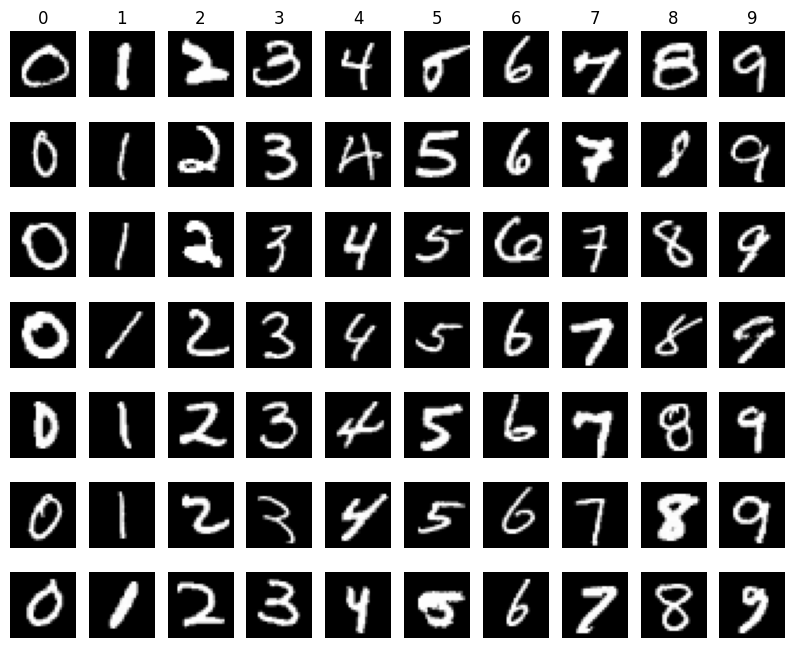

In [233]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = list(range(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((28, 28)))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Data normalization is an important step which ensures that each input parameter has a similar data distribution. This makes convergence faster while training the network.

In [234]:
X_train, X_val, X_test = get_normalized_MNIST_data(X_train, X_val, X_test)

# Train a Good Model!
Please open the file `solver.py` and read through it to familiarize yourself with the API.

In [235]:
MNIST_best_model = None

D, H1, H2, H3, H4, C = 784, 30, 20, 20, 20, 10

data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
    }

model = FullyConnectedNet(
    "classification",
    [H1, H2, H3, H4],
    [True, True, True, True],
    input_dim=D,
    output_dim=C,
    reg=0,
    weight_scale=5e-2,
    dtype=np.float64
)
solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=10,
                print_every=100)
solver.train()

MNIST_solver = solver
MNIST_best_model = model

(Iteration 1 / 50000) loss: 2.275082
(Epoch 0 / 10) train acc: 0.145000; val_acc: 0.129900
(Iteration 101 / 50000) loss: 2.217250
(Iteration 201 / 50000) loss: 2.135171
(Iteration 301 / 50000) loss: 1.874045
(Iteration 401 / 50000) loss: 1.811117
(Iteration 501 / 50000) loss: 1.801735
(Iteration 601 / 50000) loss: 1.251223
(Iteration 701 / 50000) loss: 1.667207
(Iteration 801 / 50000) loss: 1.348916
(Iteration 901 / 50000) loss: 0.905421
(Iteration 1001 / 50000) loss: 0.836476
(Iteration 1101 / 50000) loss: 0.897992
(Iteration 1201 / 50000) loss: 0.941821
(Iteration 1301 / 50000) loss: 0.939117
(Iteration 1401 / 50000) loss: 0.895133
(Iteration 1501 / 50000) loss: 0.624966
(Iteration 1601 / 50000) loss: 1.346461
(Iteration 1701 / 50000) loss: 1.472930
(Iteration 1801 / 50000) loss: 0.561991
(Iteration 1901 / 50000) loss: 1.035361
(Iteration 2001 / 50000) loss: 0.835672
(Iteration 2101 / 50000) loss: 0.335760
(Iteration 2201 / 50000) loss: 0.711497
(Iteration 2301 / 50000) loss: 0.20579

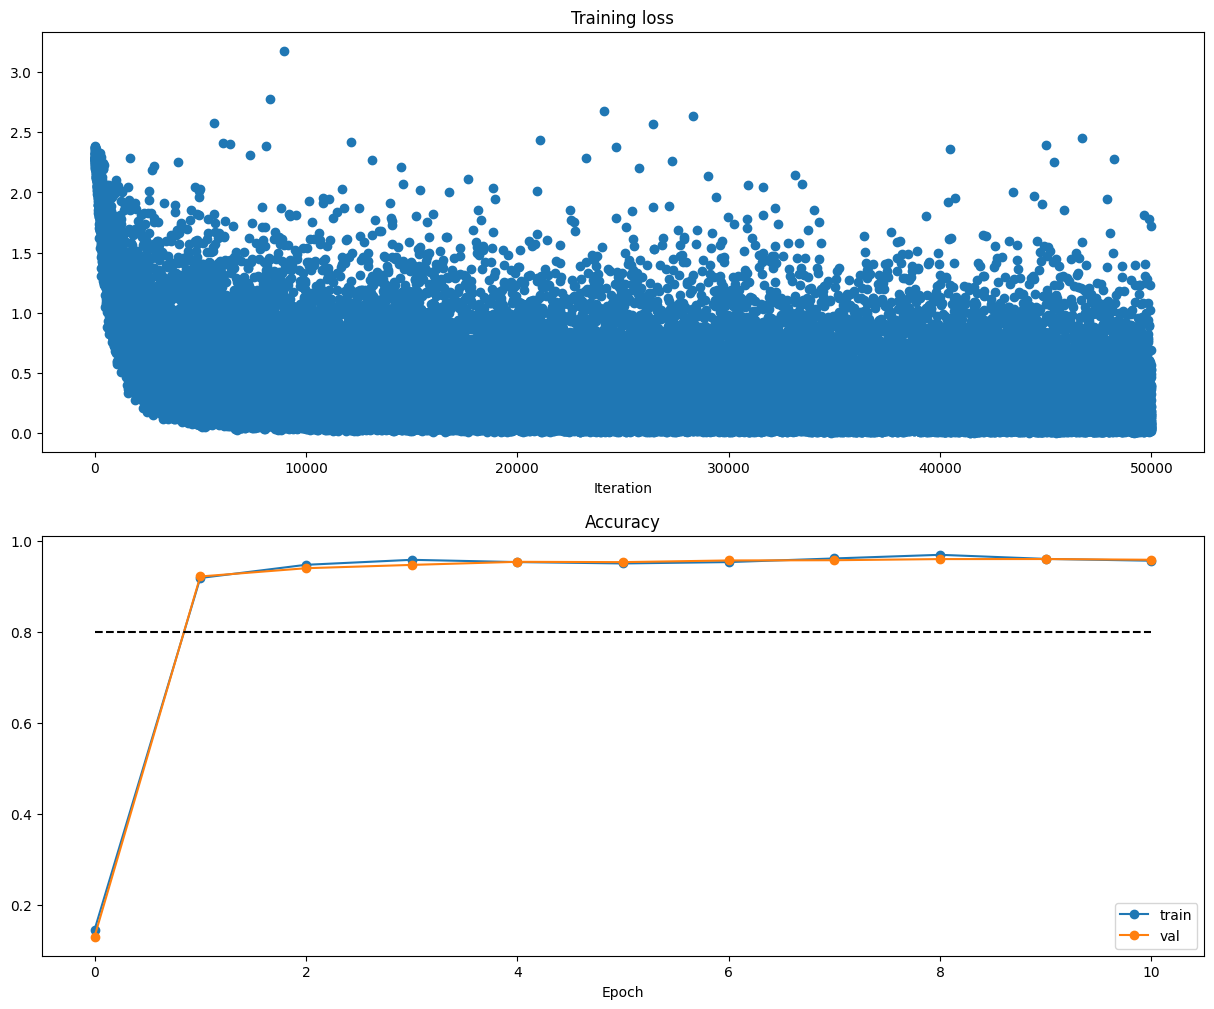

In [236]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(MNIST_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(MNIST_solver.train_acc_history, '-o', label='train')
plt.plot(MNIST_solver.val_acc_history, '-o', label='val')
plt.plot([0.8] * len(MNIST_solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Test Model!

In [237]:
y_test_pred = np.argmax(MNIST_best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(MNIST_best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.9543
Test set accuracy:  0.9506


# California housing dataset
This is a dataset obtained from the [StatLib repository](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html). The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data.

In [224]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [225]:
X_train, y_train, X_val, y_val, X_test, y_test = get_california_housing_data()
print('Train data shape: ', X_train.shape)
print('Train target values shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation target values shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test target values shape: ', y_test.shape)

Train data shape:  (15640, 8)
Train target values shape:  (15640,)
Validation data shape:  (2500, 8)
Validation target values shape:  (2500,)
Test data shape:  (2500, 8)
Test target values shape:  (2500,)


In [226]:
X_train, X_val, X_test = get_california_housing_normalized__data(X_train, X_val, X_test)

# Train a Good Model!

In [227]:
california_housing_best_model = None

D, H1, H2, H3, H4, C = 8, 10, 10, 10, 10, 1


data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
    }

model = FullyConnectedNet(
    "regression",
    [H1, H2, H3, H4],
    [True, True, True, True],
    input_dim=D,
    output_dim=C,
    reg=0,
    weight_scale=5e-2,
    dtype=np.float64
)

solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=5, batch_size=200,
                print_every=100)
solver.train()

california_housing_solver = solver
california_housing_best_model = model

(Iteration 1 / 390) loss: 3.803726
(Epoch 0 / 5) train RMS error: 1.989599; val RMS error: 2.716817
(Epoch 1 / 5) train RMS error: 0.771409; val RMS error: 1.518892
(Iteration 101 / 390) loss: 0.637314
(Epoch 2 / 5) train RMS error: 0.707991; val RMS error: 1.505576
(Iteration 201 / 390) loss: 0.659261
(Epoch 3 / 5) train RMS error: 0.691277; val RMS error: 1.535371
(Iteration 301 / 390) loss: 0.636551
(Epoch 4 / 5) train RMS error: 0.716704; val RMS error: 1.560349
(Epoch 5 / 5) train RMS error: 0.718947; val RMS error: 1.605707


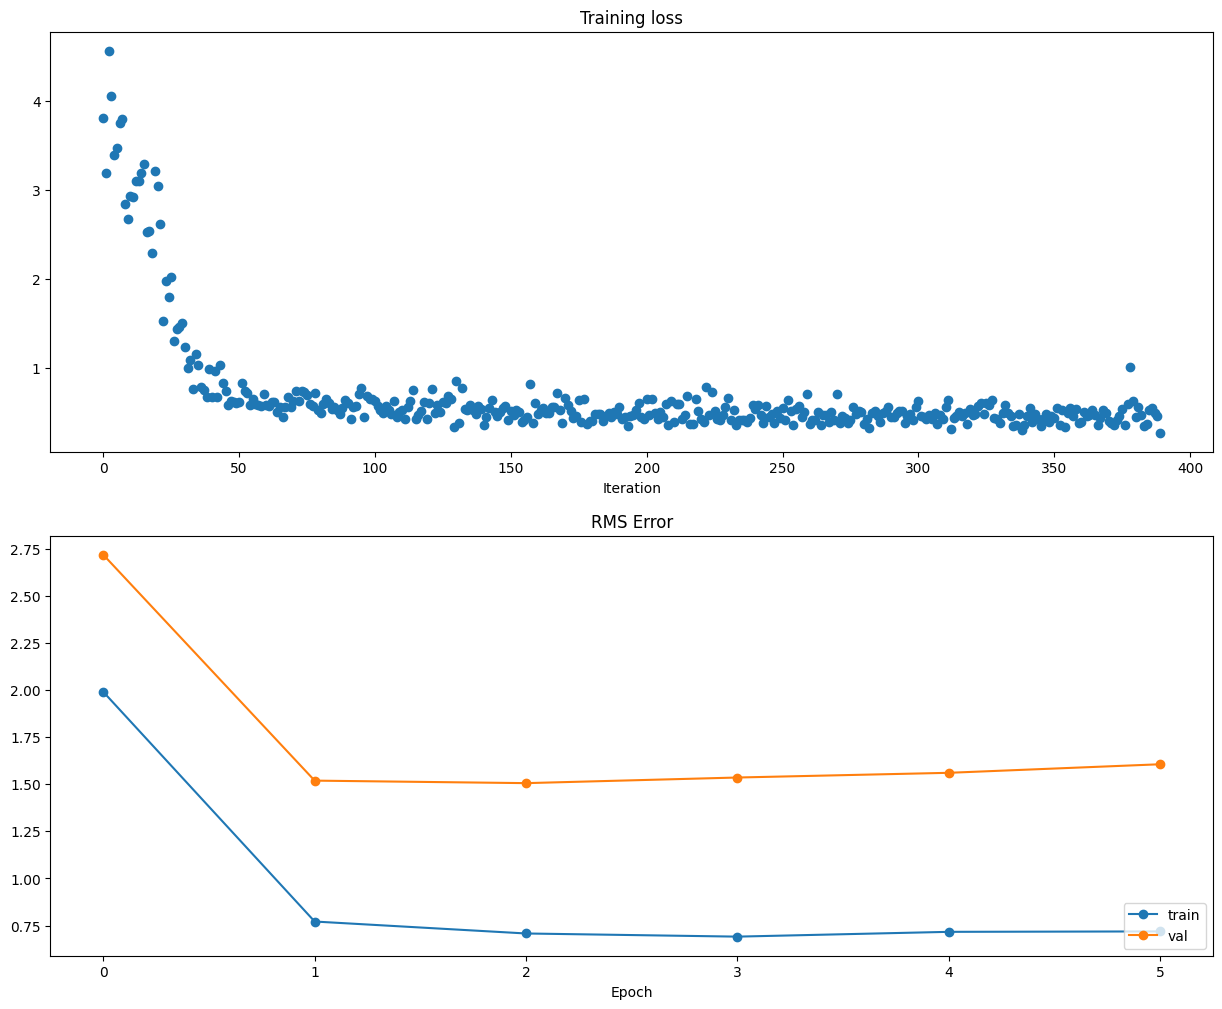

In [228]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(california_housing_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('RMS Error')
plt.plot(california_housing_solver.train_acc_history, '-o', label='train')
plt.plot(california_housing_solver.val_acc_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

Done!